# 04. Aperture Photometry of a Single Object

Here we will use ``photutils`` and show how the photometry works. In real scientific work, you need more advanced statistical analysis and techniques, but this note will give you a quick look at the "skeleton" you have to use.

I will select one single star my manual coding (_hard coded_) and find its centroid, aperture sum, estimate sky, and finally obtain the instrumental magnitude.

**Installation**

``ysvisutilpy``: 

    git clone https://github.com/ysBach/ysvisutilpy
    cd ysvisutilpy && python setup.py install

## 1. Importing and Setting Up

(You don't have to run the first code cell just below)

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, matplotlib, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-05-02 11:00:28 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.5.0 x86_64 i386 64bit
3 astropy    3.1.2
4 numpy      1.16.2
5 matplotlib 3.0.3
6 photutils  0.6
7 version_information 1.0.3


In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.stats import sigma_clipped_stats
from astropy.nddata import Cutout2D

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.centroids import centroid_com
from photutils import aperture_photometry as apphot

from matplotlib import pyplot as plt
from matplotlib import rcParams

import ysvisutilpy as yvu
import warnings
warnings.filterwarnings('ignore', append=True, category=UserWarning)

DATAPATH = Path('../..') / 'Tutorial_Data'

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

## 2. Loading and Cut Data
For FITS loading, please refer to the notebook on FITS file handing (02-Opening FITS).

Here, only the last line is added:
* Cut the image with [``astropy.nddata.Cutout2D``](https://docs.astropy.org/en/stable/api/astropy.nddata.utils.Cutout2D.html).
* I cut the image centered at ``position=(270, 320)`` and size of ``size=(100, 100)`` pixels.

More tutorials on this module can be found at the official documentation on [image utilities](https://docs.astropy.org/en/stable/nddata/utils.html).

In [7]:
allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

hdul = fits.open(allfits[0])
hdr = hdul[0].header
data = hdul[0].data
cut_hdu = Cutout2D(data=data, position=(270,320), size=(100,100))

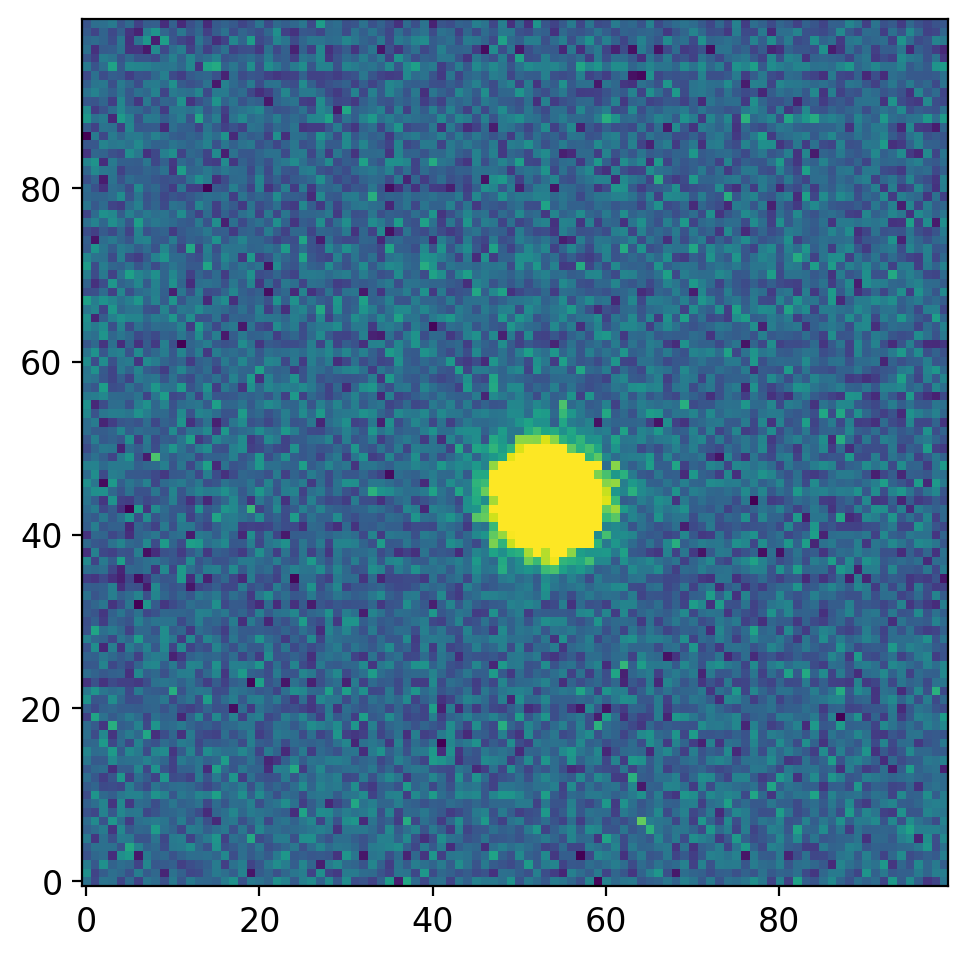

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.zimshow(axs, cut_hdu.data)
plt.tight_layout()

## 3. Finding Centroid
The center of mass from the image is calculated by [``photutils.centroids.centroid_com``](https://photutils.readthedocs.io/en/stable/api/photutils.centroids.centroid_com.html#photutils.centroids.centroid_com). For a bit more of the tutorial, visit official [``centroids`` documentation](https://photutils.readthedocs.io/en/stable/centroids.html). 

I did
* Do sigma-clipping to the cutout data. Get statistics of the clipped data.
* Set the threshold as median plus 3-sigma.
* Get centroid by center of mass algorithm using only the pixels above that threshold level.


In [9]:
avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.
thresh_3sig = med + 3 * std
mask_3sig = (cut_hdu.data < thresh_3sig)
center = centroid_com(data=cut_hdu.data, mask=mask_3sig)
print(center)

[53.06534898 44.04455484]


In the code below, I overplotted the image onto the ``mask_3sig``. The faint background-like feature is the original image, and the highlight means the pixels used for the centroid calculation. Red cross is the thus found centroid.

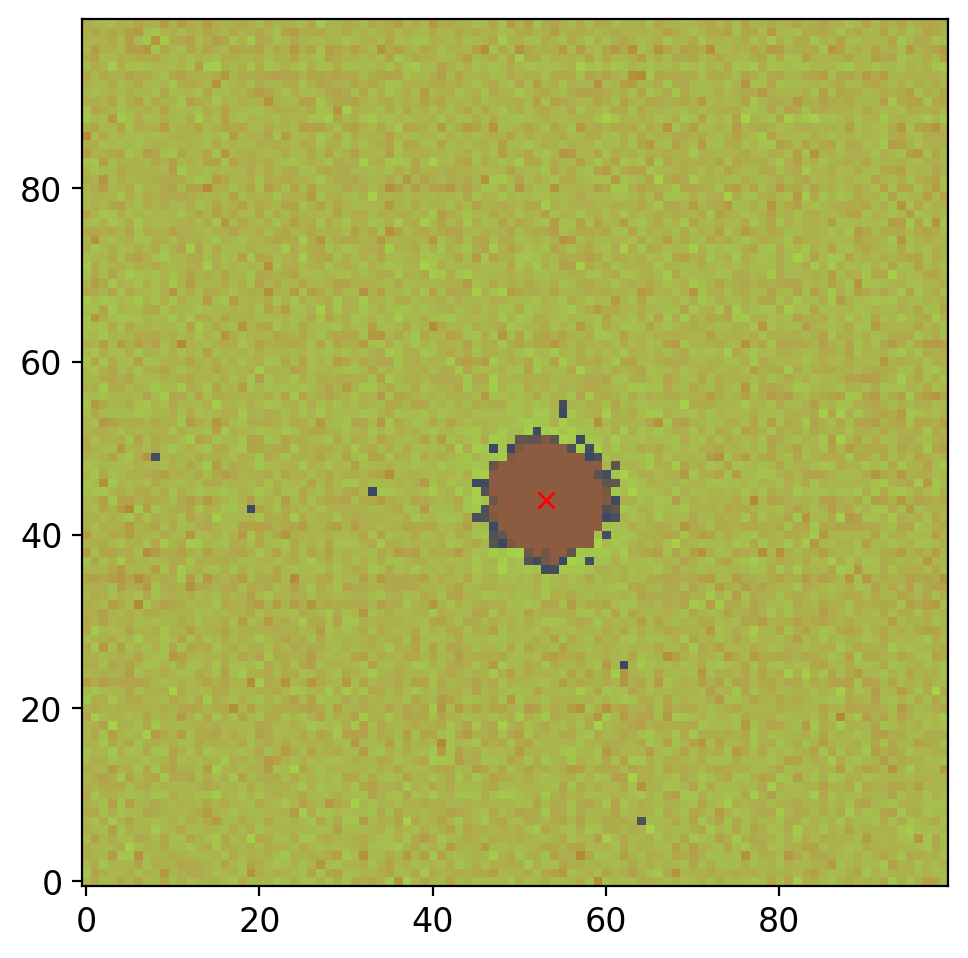

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.zimshow(axs, mask_3sig.astype(int))
yvu.zimshow(axs, cut_hdu.data, alpha=0.4)
axs.plot(*center, 'rx')
plt.tight_layout()

* **TIP**: In realistic centroiding, this method **should not be used**. This is becasue virtually all of the photometric information is contained in only very small area around the true center, so we need to do centroiding using, e.g., cbox size of ~ 1-3 FWHM to minimize error sources. What you have to do is to cutout only a small region near the center of the object and do centroiding. This is not an easy task to realize, so it is better to use pre-made packages, such as ysphotutilpy.

## 4. Putting Aperture and Annulus

* From simple analysis, I found the FWHM of the point sources in the image is roughly 4 pixels. I will use this value throughout this note.
* I will set aperture radius to 1.5 FWHM $ \sim 2 \times 4 = 8$ pixels, and the inner and outer radii of annuli to be 4 and 6 FWHM, which are 16 and 24 pixels, respectively.

A good descriptive tutorial on using ``photutils`` for aperture photometry is given in the official documentation of the [aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html#local-background-subtraction). Here, I will do similar things but in a simpler way. If you have more than 1 star, you may need to look at the documentation and learn how to use for-loop effectively.

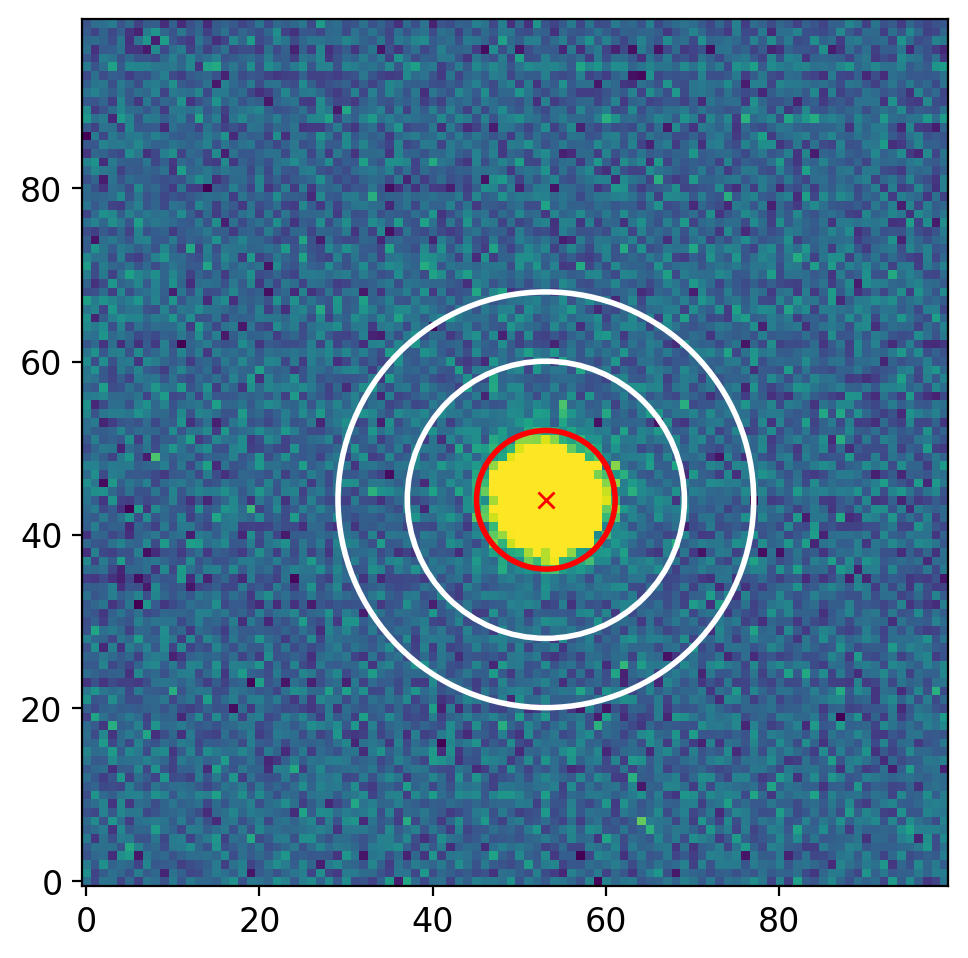

In [13]:
fwhm = 4
r_ap = 2 * fwhm
r_in = 4 * fwhm
r_out = 6 * fwhm
ap = CAp(positions=center, r=r_ap)
an = CAn(positions=center, r_in=r_in, r_out=r_out)

fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.zimshow(axs, cut_hdu.data)
ap.plot(ax=axs, color='r', lw=2)
an.plot(ax=axs, color='w', lw=2)
axs.plot(*center, 'rx')
plt.tight_layout()

## 5. Estimating Sky

As in the [aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html#local-background-subtraction) documentation, I here used the ``to_mask()`` method of the annulus object, and the ``.multiply`` method to extract the sky-region as ``sky_vals``.

Then I used the SExtractor sky estimation algorithm (see the Book chapter on SExtractor sky), showed crude histogram with estimated sky value.

Sky estimation: 82.564 +- 8.417


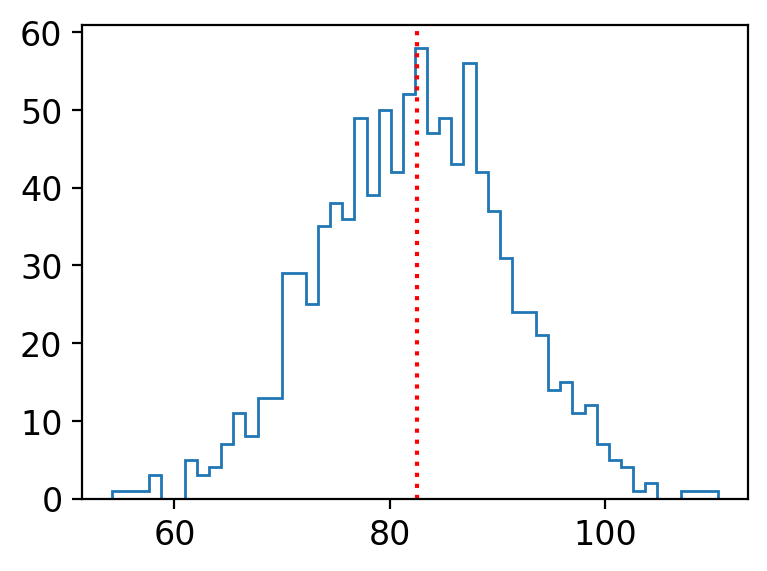

In [15]:
sky_mask = an.to_mask(method='center')
try:  # prior to photutils 0.7
    sky_vals = sky_mask[0].multiply(cut_hdu.data)
except TypeError:
    sky_vals = sky_mask.multiply(cut_hdu.data)
    
sky_vals = sky_vals[sky_vals > 0]
avg, med, std = sigma_clipped_stats(sky_vals, sigma=3, maxiters=10, std_ddof=1)

if med - avg < 0.3 * std:
    msky = med
else:
    msky = 2.5 * med - 1.5 * avg

print(f"Sky estimation: {msky:.3f} +- {std:.3f}")
    
fig, axs = plt.subplots(1, 1, figsize=(4, 3), sharex=False, sharey=False, gridspec_kw=None)

axs.hist(sky_vals, 50, histtype='step')
axs.axvline(msky, ls=':', color='r')
plt.tight_layout()

## 6. Do Photometry
Then we can do photometry using [``aperture_photometry``](https://photutils.readthedocs.io/en/stable/api/photutils.aperture_photometry.html#photutils.aperture_photometry) of ``photutils`` (I used the name ``apphot`` for short).

I here determined the sky, source sum ($ = \mathrm{aperture\_sum} - \mathrm{area}_\mathrm{aperture} \times \mathrm{sky}$), and the instrumental magnitude ($ = -2.5 \log_{10} \frac{\mathrm{source\_sum}}{t_\mathrm{exp}} $, where $ t_\mathrm{exp} $ is the exposure time in seconds)

In [17]:
phot = apphot(data=cut_hdu.data, apertures=ap)
phot["sky"] = msky
try:  # prior to photutils 0.7
    phot["source_sum"] = phot["aperture_sum"] - ap.area() * phot["sky"]
except TypeError:
    phot["source_sum"] = phot["aperture_sum"] - ap.area * phot["sky"]
    
phot["inst_mag"] = -2.5 * np.log10(phot["source_sum"] / hdr["EXPTIME"])
phot

id,xcenter,ycenter,aperture_sum,sky,source_sum,inst_mag
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,53.06534897903476,44.04455484023454,71827.95125716334,82.56420135498047,55227.43359787918,-7.410009029439574


As a result, what you obtained are:
* Center of the object is (x, y) = (53.065, 44.045) pixel in the coordinate of the cutout image.
* Aperture sum is 71827.95 ADU, and the sky is estimated as 82.564 ADU / pixel.
* The sky subtracted flux is 55227.43 ADU during the exposure time.
* The instrumental magnitude is -7.41 magnitude.

One missing thing here is the uncertainty of the values (e.g., $\Delta m$). This is a complicated topic, and I will distribute simplified package to do all the photometry with automatic error-calculation.